In [1]:
!pip install tensorflow-text==2.6

In [2]:
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from wordcloud import WordCloud

# Preprocessing and evaluation
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. Load Data

In [3]:
df = pd.read_csv('../input/spotify-app-reviews-2022/reviews.csv')
df.head()

In [4]:
df.info()

In [5]:
#set color for data visualization
sns.set(rc={"axes.facecolor":"#e6ffed","figure.facecolor":"#e6ffed", "grid.color":"#99e2b4",
            "axes.edgecolor":"#99e2b4", "axes.labelcolor":"#195e2d", "xtick.color":"#195e2d",
            "ytick.color":"#195e2d"})

# ['#4a7c59', '#68b0ab', '#8fc0a9', '#c8d5b9', '#faf3dd']
palettes = ['#eee82c', '#91cb3e', '#53a548', '#4c934c', '#19381f']
cmap = colors.ListedColormap(['#137547', '#2a9134', '#3fa34d', '#5bba6f', '#19381f'])

# 1. Data Cleaning & EDA

In [ ]:
df['Reply'].isna().sum()

In [7]:
reply = df[~df['Reply'].isna()]

ax = sns.countplot(reply['Rating'], palette=palettes, edgecolor=palettes)
ax.set_title('Rating of Replied Reviews')

Obviously, an admin replied reviews rated 1 to check complaints and assure customers' satisfaction.

In [8]:
plt.figure(figsize=(10,10))
wc = WordCloud(max_words=1000, min_font_size=10, height=600, width=1200, collocations=False,
               background_color='#e6ffed', colormap='summer').generate(' '.join(reply['Reply']))

plt.axis('off')
plt.imshow(wc)

* positive: love, happy, recommend 
* negative: sorry, tried, reinstalling
* neutral: Service, Contact, Hey, Customer, support, help, hear, spotify

In [9]:
def top_words(text):
    word = pd.DataFrame(wc.process_text(''.join(text)).items()).sort_values(1, ascending=False)
    
    print('Top 5 words that appear most frequently:\n')
    for i in range(5):
        item = word.iloc[i]
        print(item[0] + '\t--> ' + str(item[1]))

In [10]:
top_words(reply['Reply'])

### data relationship with time or date

In [11]:
df['Time_submitted'] = pd.to_datetime(df['Time_submitted'])

df['Date'] = df['Time_submitted'].apply(lambda x: x.date())

reviews_per_day = df.groupby(df['Date']).count()['Review']
reviews_per_day = reviews_per_day.reset_index()
reviews_per_day['Month'] = reviews_per_day['Date'].apply(lambda x: x.month)

In [12]:
reviews_per_day.rename(columns={'Review':'Total_review'}, inplace=True)
reviews_per_day.head()

In [13]:
ax = sns.lineplot(data=reviews_per_day, x='Date', y='Total_review', color='#4c934c')
ax.set_title('Total Review per Day')

In [14]:
g = sns.FacetGrid(data=reviews_per_day, col='Month', col_wrap=4)
g.map(plt.plot, 'Total_review', color='#4c934c')
g.set_axis_labels(x_var='Day', y_var='Total Review')

In [15]:
ax = sns.displot(data=reviews_per_day, x='Total_review', kind='kde', fill=True, color='#4c934c')

## Rating
We are going to transform the rating from **integer to string** and let's see the relationship between **rating and length of words**

In [16]:
# Let's change the rating to be more general and easier to understand
def rating(score):
    if score > 3:
        return 'Good'
    elif score == 3:
        return 'Netral'
    else:
        return 'Bad'

In [17]:
ax = sns.countplot(data=df, x='Rating', palette=palettes, edgecolor=palettes)
ax.set_title('Rating Distribution Across Dataset')

In [18]:
df['Rating'] = df['Rating'].apply(rating)
ax = sns.countplot(data=df, x='Rating', palette=palettes, edgecolor=palettes)
ax.set_title('Rating Distribution Across Dataset\nAfter Transformation')

In [19]:
df['Length'] = df['Review'].apply(len)
ax = sns.displot(data=df, x='Length', hue='Rating', kind='kde', fill=True, aspect=4, palette='viridis')

In [20]:
ax = sns.stripplot(data=df, x='Rating', y='Length', alpha=0.5, palette=palettes, edgecolor=palettes)
ax.set_title('Distribution of review Length\nfor Each Rating')

As you can see on the graph above, most of the reviews stuck at **500 length**. 

It's make sense since **the text limit is 500**. If you realize there are some exceptions for a certain user.

In [21]:
ax = sns.pointplot(data=df, x='Rating', y='Length', color='#4c934c')
ax.set_title('Average of review Length\nfor Each Rating')

## Total Thumbs Up
The review which got the most thumbs up

In [22]:
max_thumb = df['Total_thumbsup'].max()
print(df[df['Total_thumbsup'] == max_thumb].iloc[0]['Review'])

In [23]:
mean_thumb = df['Total_thumbsup'].mean()

ax = sns.barplot(data=df, y='Rating', x='Total_thumbsup', orient='h', ci=None, palette=palettes, edgecolor=palettes)
ax.set_title('Average Received Thumbs Up\nfor Each Rating')
plt.axvline(mean_thumb, color='red', ls='--')
plt.text(x=8, y=-0.2, s='Mean: ' + str(round(mean_thumb, 2)), color='#ee6055', weight='bold')

In [24]:
ax = sns.stripplot(data=df, x='Rating', y='Total_thumbsup', palette=palettes, edgecolor=palettes, alpha=0.5)
ax.set_title('Distribution of Received Thumbs Up\nfor Each Rating')

##  Review
Let's explore the review text and find out **the most frequent words**

In [25]:
# Most popular word for good review
good = df[df['Rating'] == 'Good']['Review']

plt.figure(figsize=(10,10))
wc = WordCloud(max_words=1000, min_font_size=10, height=600, width=1200, collocations=False,
               background_color='#e6ffed', colormap='summer').generate(' '.join(good))

plt.axis('off')
plt.imshow(wc)

In [26]:
top_words(good)

In [27]:
# Most popular word for netral review
netral = df[df['Rating'] == 'Netral']['Review']

plt.figure(figsize=(10,10))
wc = WordCloud(max_words=1000, min_font_size=10, height=600, width=1200, collocations=False,
               background_color='#e6ffed', colormap='summer').generate(' '.join(netral))

plt.axis('off')
plt.imshow(wc)

In [28]:
top_words(netral)

In [29]:
# Most popular word for bad review
bad = df[df['Rating'] == 'Bad']['Review']

plt.figure(figsize=(10,10))
wc = WordCloud(max_words=1000, min_font_size=10, height=600, width=1200, collocations=False,
               background_color='#e6ffed', colormap='summer').generate(' '.join(bad))

plt.axis('off')
plt.imshow(wc)

In [30]:
top_words(bad)

## Drop unused columns

In [31]:
df.head()

In [32]:
df_final = df[['Review', 'Rating', 'Length']]

# 2. Text Preprocessing

In [33]:
# Total word in dataset before cleaning
length = df_final['Length'].sum()

## Stemming vs Lemmatization

I think this picture can give you a sense of what is the different between stemming and lemmatization
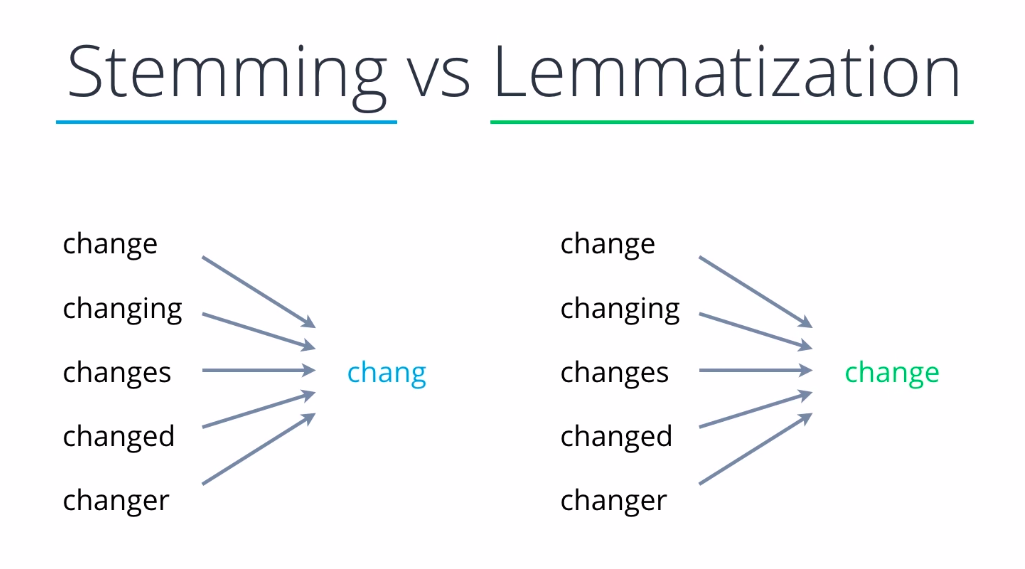

In [34]:
print('Original:')
print(df['Review'][7])
print()

sentence = []
for word in df['Review'][7].split():
    stemmer = SnowballStemmer('english')
    sentence.append(stemmer.stem(word))
print('Stemming:')
print(' '.join(sentence))
print()

sentence = []
for word in df['Review'][7].split():
    lemmatizer = WordNetLemmatizer()
    sentence.append(lemmatizer.lemmatize(word, 'v'))
print('Lemmatization:')
print(' '.join(sentence))

There are some difference among those 3 sentences, for instance:

* Original -> changing, convinced
* Stemming -> chang, convinc
* Lemmatization -> change, convince

This time, we will use Lemmatization in order to **get the base** form of the word

In [35]:
def cleaning(text):
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()
    
    #remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]
    
    #lemmatize the word
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

In [36]:
df['Review'] = df['Review'].apply(cleaning)

In [37]:
df['Length'] = df['Review'].apply(len)
new_length = df['Length'].sum()

print('Total word before cleaning: {}'.format(length))
print('Total word after cleaning: {}'.format(new_length))

In [38]:
X_train, X_test, y_train, y_test = train_test_split(df['Review'], df['Rating'], test_size=0.2)

# 3. Build Model

## LSTM

Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems

## Three basic requirements of a recurrent neural network

* That the system be able to store information for an arbitrary duration.
* That the system be resistant to noise (i.e. fluctuations of the inputs that are random or irrelevant to predicting a correct output).
* That the system parameters be trainable (in reasonable time).

In [39]:
tokenizer = Tokenizer(num_words=50000, oov_token='<OOV>')

tokenizer.fit_on_texts(X_train)
# print(tokenizer.word_index)
total_word = len(tokenizer.word_index)
print('Total distinct words: {}'.format(total_word))

train_seq = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seq)

test_seq = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_seq)

# One hot encoding the label
lb = LabelBinarizer()
train_labels = lb.fit_transform(y_train)
test_labels = lb.transform(y_test)

In [40]:
model_lstm = tf.keras.models.Sequential([tf.keras.layers.Embedding(total_word, 8),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(16, activation='relu'),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(3, activation='softmax')])

model_lstm.summary()

In [41]:
model_lstm.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model_lstm.fit(train_padded, train_labels, epochs=10, validation_data=(test_padded, test_labels))

In [42]:
metrics_lstm = pd.DataFrame(model_lstm.history.history)
metrics_lstm[['accuracy', 'val_accuracy']].plot()
metrics_lstm[['loss', 'val_loss']].plot()

## GRU

Gated recurrent units are a gating mechanism in recurrent neural networks, introduced in 2014 by Kyunghyun Cho et al. The GRU is like a long short-term memory with a forget gate, but has fewer parameters than LSTM, as it lacks an output gate. Another Interesting thing about  GRU is that, unlike LSTM, it does not have a separate cell state (Ct). It only has a hidden state(Ht). Due to the simpler architecture, GRUs are faster to train.

In [43]:
model_gru = tf.keras.models.Sequential([tf.keras.layers.Embedding(total_word, 8),
                                    tf.keras.layers.GRU(8),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(3, activation='softmax')])

model_gru.summary()

In [44]:
model_gru.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model_gru.fit(train_padded, train_labels, epochs=25, validation_data=(test_padded, test_labels))

In [45]:
metrics_gru = pd.DataFrame(model_gru.history.history)
metrics_gru[['accuracy', 'val_accuracy']].plot()
metrics_gru[['loss', 'val_loss']].plot()

There are not many difference between LSTM and GRU in terms of accuracy and loss. So, in the following cell, we will build model using ELECTRA Transformer and see the overall performance

## ELECTRA

ELECTRA is a new pretraining approach which trains two transformer models: the generator and the discriminator. It stands for Efficiently Learning an Encoder that Classifies Token Replacements Accurately and it is a BERT-like model. The generator’s role is to replace tokens in a sequence, and is therefore trained as a masked language model. The discriminator, which is the model we’re interested in, tries to identify which tokens were replaced by the generator in the sequence

In [46]:
bert_preprocess_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_encoder_url = 'https://tfhub.dev/google/electra_base/2'

bert_preprocess = hub.KerasLayer(bert_preprocess_url)
bert_encoder = hub.KerasLayer(bert_encoder_url)

In [47]:
# Example
def bert_example(sentence):
    preprocessed_text = bert_preprocess(sentence)
    return bert_encoder(preprocessed_text)['pooled_output']

In [48]:
exp = bert_example(['cat', 'dog', 'eye', 'nose'])

from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity([exp[0]], [exp[1]])) # flower and vegetable
print(cosine_similarity([exp[0]], [exp[2]])) # flower and eye
print(cosine_similarity([exp[2]], [exp[3]])) # eye and nose

## Result
* Cat and dog both are animal. Thus, the similarity between them is pretty high
* Eye and nose both are part of the body. Thus, the similarity between them is also pretty high
* However, cat and eye can't be compared straight away because they are totally different. Thus, they got lower similarity

In [49]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessed_text = bert_preprocess(text_input)
output = bert_encoder(preprocessed_text)

# DNN
x = tf.keras.layers.Dropout(0.2)(output['pooled_output'])
x = tf.keras.layers.Dense(3, activation='softmax')(x)

# Build the model
model_bert = tf.keras.Model(text_input, x)

In [50]:
model_bert.summary()

In [ ]:
model_bert.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(learning_rate=0.0005),
                   metrics=['accuracy'])

model_bert.fit(X_train, train_labels, epochs=25, batch_size=32, validation_data=(X_test, test_labels))

In [ ]:
metrics_bert = pd.DataFrame(model_bert.history.history)
metrics_bert[['accuracy', 'val_accuracy']].plot()
metrics_bert[['loss', 'val_loss']].plot()

# 4. Prediction

In [ ]:
def lstm_prediction(text):
    clean_text = cleaning(text)
    seq = tokenizer.texts_to_sequences([clean_text])
    padded = pad_sequences(seq)

    pred = model_lstm.predict(padded)
    # Get the label name back
    result = lb.inverse_transform(pred)[0]
    
    return result

def gru_prediction(text):
    clean_text = cleaning(text)
    seq = tokenizer.texts_to_sequences([clean_text])
    padded = pad_sequences(seq)

    pred = model_gru.predict(padded)
    # Get the label name back
    result = lb.inverse_transform(pred)[0]
    
    return result

def bert_prediction(text):
    clean_text = cleaning(text)
    
    pred = model_bert.predict([clean_text])
    # Get the label name back
    result = lb.inverse_transform(pred)[0]
    
    return result

In [ ]:
text1 = "There is a major bug in the app. I can't play my playlist since the last 2 days"

print('LSTM\t: ', lstm_prediction(text1))
print('GRU\t: ', gru_prediction(text1))
print('BERT\t: ', bert_prediction(text1))

In [ ]:
text2 = "Love this app! the interface is clean and pleasing to the eye"

print('LSTM\t: ', lstm_prediction(text2))
print('GRU\t: ', gru_prediction(text2))
print('BERT\t: ', bert_prediction(text2))

In [ ]:
text3 = "The overall experience is good, but the ads really annoying"

print('LSTM\t: ', lstm_prediction(text3))
print('GRU\t: ', gru_prediction(text3))
print('BERT\t: ', bert_prediction(text3))